In [0]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

import time

In [3]:
tf.__version__

'2.2.0-rc2'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


$$ f=\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}+\frac{\partial p}{\partial x}-\frac{1}{\mathrm{Re}}\Delta u$$

$$ g=\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}+\frac{\partial p}{\partial y}-\frac{1}{\mathrm{Re}}\Delta v$$

$$\nabla・(u,v)=0$$

## 目的
Input:
- $x$
- $y$
- $t$

Output:
- $u = \frac{\partial \phi}{\partial y}$
- $v = -\frac{\partial \phi}{\partial z}$
- $p$

In [0]:
class SimpleNeuralNetwork(Model):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.layer1 = Dense(10, activation='tanh')
        self.layer2 = Dense(10, activation='tanh')
        self.outputLayer = Dense(2)

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.outputLayer(x)

def create_model():
    inputs = tf.keras.layers.Input((3,), dtype=tf.float32)
    x = tf.keras.layers.Dense(20, activation="tanh")(inputs)
    x = tf.keras.layers.Dense(20, activation="tanh")(x)
    x = tf.keras.layers.Dense(20, activation="tanh")(x)
    x = tf.keras.layers.Dense(20, activation="tanh")(x)
    x = tf.keras.layers.Dense(20, activation="tanh")(x)
    x = tf.keras.layers.Dense(2)(x)
    model = tf.keras.models.Model(inputs=inputs,
                                  outputs=x)
    return model

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, 
                 x_train, y_train, t_train, 
                 u_train, v_train, p_train):
        self.x_train = tf.Variable(x_train)
        self.y_train = tf.Variable(y_train)
        self.t_train = tf.Variable(t_train)
        
        # 何らかの条件
        self.u_train = u_train
        self.v_train = v_train
        self.p_train = p_train
        
        # パラメータ(適宜設定)
        self.Re = 100

        # モデル
        self.model = create_model()
    
    @tf.function
    def net_NS(self, x, y, t):
        # with tf.GradientTape() as tape_xxx, tf.GradientTape() as tape_yyy:
        #     tape_xxx.watch(x)
        #     tape_yyy.watch(y)
        #     with tf.GradientTape() as tape_xx, tf.GradientTape() as tape_yy, tf.GradientTape() as tape_t:
        #         tape_xx.watch(x)
        #         tape_yy.watch(y)
        #         tape_t.watch(t)
        #         with tf.GradientTape() as tape_x, tf.GradientTape() as tape_y:
        #             tape_x.watch(x)
        #             tape_y.watch(y)
        #             inputs = tf.concat([x,y,t],axis=1)
        #             out = self.model(inputs)
        #         out_dx = tape_x.gradient(out, x)
        #         v = - out_dx[:,0]
        #         p_x = out_dx[:,1]
        #         out_dy = tape_y.gradient(out, y)
        #         u = out_dy[:,0]
        #         p_y = out_dy[:,1]
        #         velocity = tf.concat([u, v], axis=1)
        #     velocity_dx = tape_xx.gradient(velocity, x)
        #     velocity_dy = tape_yy.gradient(velocity, y)
        #     velocity_dt = tape_t.gradient(velocity, t)
        # velocity_dx2 = tape_xxx.gradient(velocity_dx, x)
        # velocity_dy2 = tape_yyy.gradient(velocity_dy, y)
        # u_x, v_x = velocity_dx[:,0], velocity_dx[:,1]
        # u_y, v_y = velocity_dy[:,0], velocity_dy[:,1]
        # u_t, v_t = velocity_dt[:,0], velocity_dt[:,1]
        # u_xx, v_xx = velocity_dx2[:,0], velocity_dx2[:,1]
        # u_yy, v_yy = velocity_dy2[:,0], velocity_dy[:,1] 


        inputs = tf.concat([x,y,t],axis=1)
        out = self.model(inputs)
        phi = out[:,0]
        p = out[:,1]
        g = tf.Graph()
        with g.as_default():
            u = tf.gradients(phi, y)[0]
            v = - tf.gradients(phi, x)[0]  
        
            u_t = tf.gradients(u, t)[0]
            u_x = tf.gradients(u, x)[0]
            u_y = tf.gradients(u, y)[0]
            u_xx = tf.gradients(u_x, x)[0]
            u_yy = tf.gradients(u_y, y)[0]

            v_t = tf.gradients(v, t)[0]
            v_x = tf.gradients(v, x)[0]
            v_y = tf.gradients(v, y)[0]
            v_xx = tf.gradients(v_x, x)[0]
            v_yy = tf.gradients(v_y, y)[0]

            p_x = tf.gradients(p, x)[0]
            p_y = tf.gradients(p, y)[0]

        f = u_t + u*u_x + v*u_y + p_x - 1/self.Re*(u_xx + u_yy) 
        g = v_t + u*v_x + v*v_y + p_y - 1/self.Re*(v_xx + v_yy)

        return u, v, p, f, g
    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))
    
    @tf.function
    def train(self):
        optimizer = tf.optimizers.Adam(1.0e-4)
        with tf.GradientTape() as tape:
            u, v, p, f, g = self.net_NS(self.x_train, self.y_train, self.t_train)
            print(u,v,p,f,g)
            loss_1 = tf.keras.losses.MSE(u,u_train)+tf.keras.losses.MSE(v,v_train)+tf.keras.losses.MSE(p,p_train)
            print(loss_1)
            loss_2 = f**2 + g**2
            loss_2 = tf.reshape(loss_2, [-1])
            print(loss_2)
            loss = loss_1+loss_2

        grad = tape.gradient(loss, sources=self.model.trainable_variables)
        # optimizerで重みを更新
        optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf:t_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        
        return u_star, v_star, p_star

In [6]:
# Load Data
data_path = '/content/drive/My Drive/研究/Master/PINN/data/cylinder_nektar_wake.mat'
data = scipy.io.loadmat(data_path)

# 訓練データの取得
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2
    
N = X_star.shape[0]
T = t_star.shape[0]
    
# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T
    
UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T
    
x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data
N_train = 1000
idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]
p_train = p[idx,:]
inputs = tf.concat([x_train, y_train, t_train], axis=1)
print(type(inputs))
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, p_train)
epoch = 1000
model.train()

<class 'tensorflow.python.framework.ops.EagerTensor'>
Tensor("StatefulPartitionedCall:0", shape=(1000, 1), dtype=float64) Tensor("StatefulPartitionedCall:1", shape=(1000, 1), dtype=float64) Tensor("StatefulPartitionedCall:2", shape=(1000,), dtype=float32) Tensor("StatefulPartitionedCall:3", shape=(1000, 1), dtype=float64) Tensor("StatefulPartitionedCall:4", shape=(1000, 1), dtype=float64)
Tensor("add_1:0", shape=(1000,), dtype=float64)
Tensor("Reshape:0", shape=(1000,), dtype=float64)
Tensor("StatefulPartitionedCall:0", shape=(1000, 1), dtype=float64) Tensor("StatefulPartitionedCall:1", shape=(1000, 1), dtype=float64) Tensor("StatefulPartitionedCall:2", shape=(1000,), dtype=float32) Tensor("StatefulPartitionedCall:3", shape=(1000, 1), dtype=float64) Tensor("StatefulPartitionedCall:4", shape=(1000, 1), dtype=float64)
Tensor("add_1:0", shape=(1000,), dtype=float64)
Tensor("Reshape:0", shape=(1000,), dtype=float64)


ValueError: ignored

In [14]:

X = np.linspace(0, 1, 50) # (nx,)
nx = X.shape[0]
Y = np.linspace(0, 1, 50) # (ny,)
ny = Y.shape[0]
print(f"x格子数:{nx}")
print(f"y格子数:{ny}")

T = np.arange(0, 1000, 1) # nt
nt = T.shape[0]
print(f"ステップ数:{nt}")

XX, YY, TT = np.meshgrid(X, Y, T) # (nx,ny,nt)
print(XX.shape)

# flatten
x = XX.flatten()[:, None] # (nx*ny*nt,1)
y = YY.flatten()[:, None]
t = TT.flatten()[:, None]

# Parameter
u = np.zeros_like(x)
v = np.zeros_like(x)
p = np.zeros_like(x)

# 初期条件と境界条件
## Initial Condition
is_ic = t==0
print(f"number of IC : {is_ic.sum()}")

## Boundary Condition
# 0.2 < x < 0.4
# 0.4 < y < 0.6
is_bc = (0.2<=x)&(x<=0.4)&(0.4<=y)&(y<=0.6)
print(f"number of BC : {is_bc.sum()}")
is_left = x==0
print(f"number of left : {is_left.sum()}")
condition = (is_ic|is_bc|is_left).squeeze(1)
print(f"number of condition : {condition.sum()}")

u[is_ic] = 1.
v[is_ic] = 0.0
p[is_ic] = 0.0
u[is_bc] = 0.0
v[is_bc] = 0.0
p[is_bc] = 0.0
u[is_left] = 1.0

# trainとして
x_train = x[condition, :]
y_train = y[condition, :]
t_train = t[condition, :]
u_train = u[condition, :]
v_train = v[condition, :]
p_train = p[condition, :]
print(x_train.shape) # all same

x格子数:50
y格子数:50
ステップ数:1000
(50, 50, 1000)
number of IC : 2500
number of BC : 100000
number of left : 50000
number of condition : 152350
(152350, 1)


In [15]:
layers = [3, 20, 20, 20, 20, 2]
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, p_train, layers)
model.train(11)

elapased time:2.384185791015625e-06
elapased time:1.430511474609375e-06


AttributeError: ignored

(40000,)


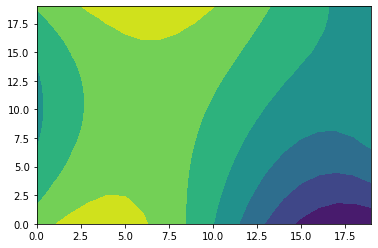

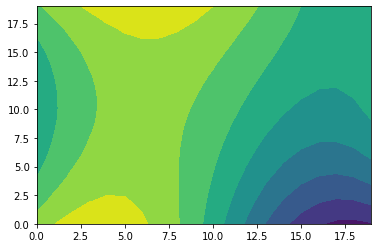

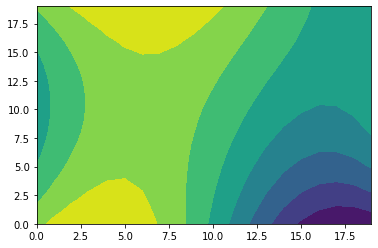

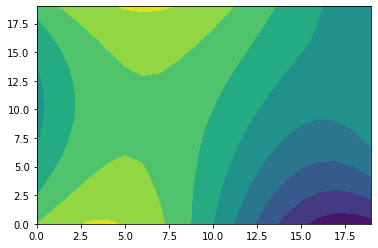

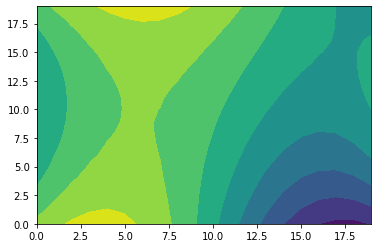

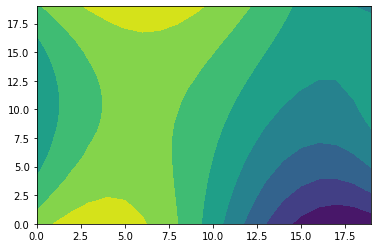

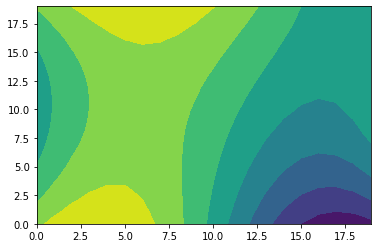

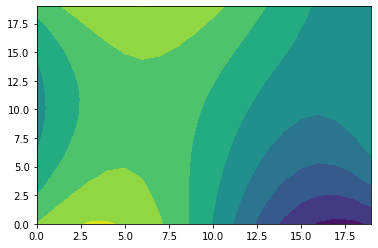

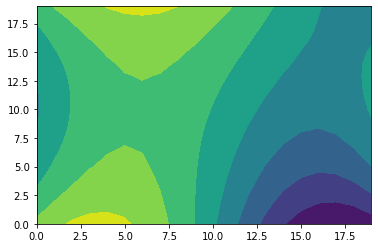

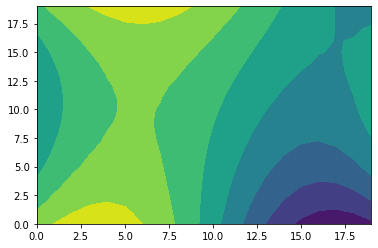

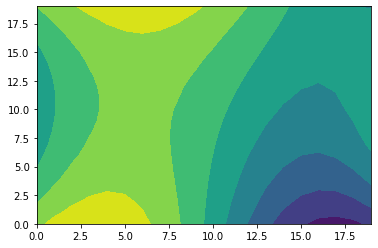

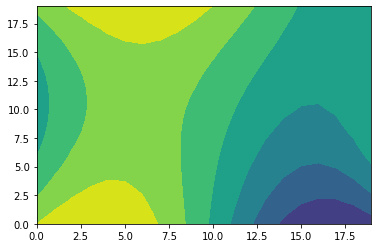

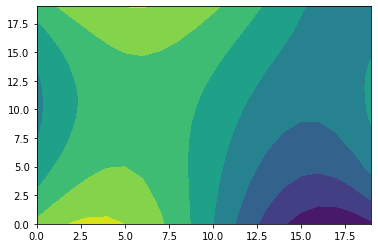

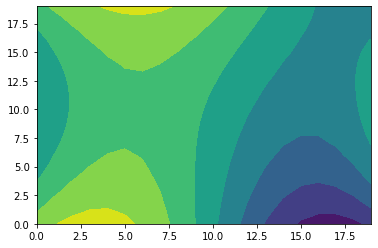

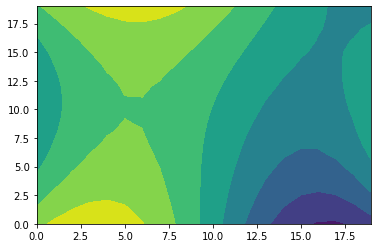

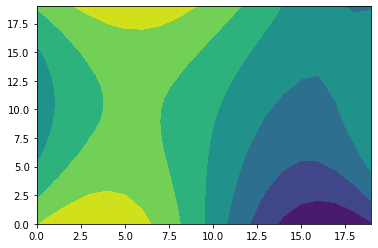

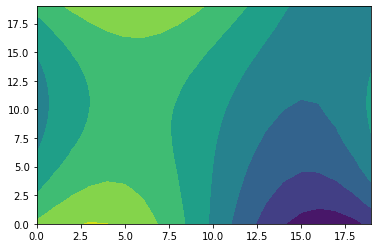

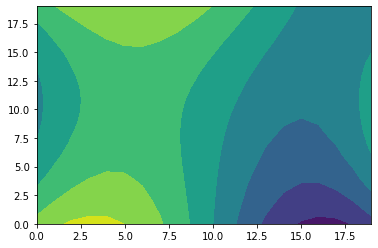

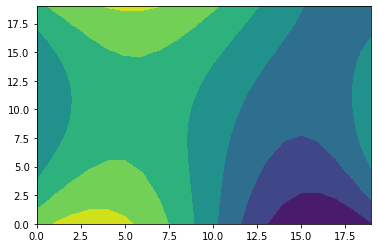

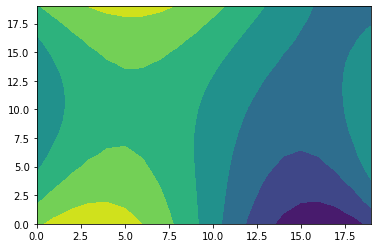

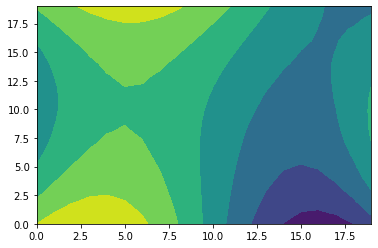

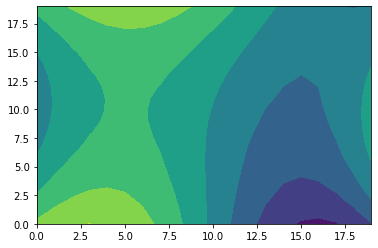

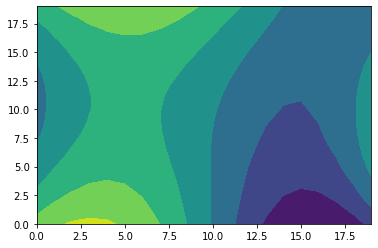

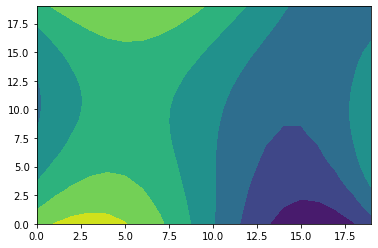

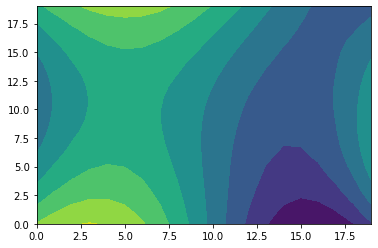

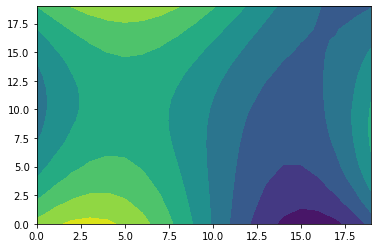

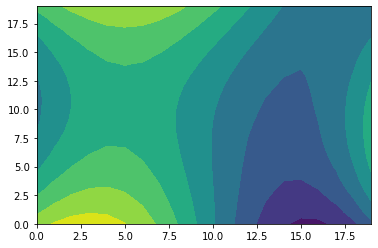

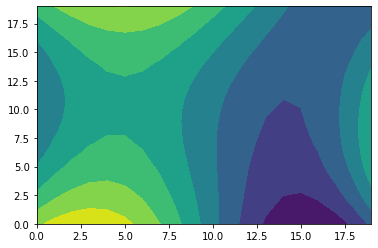

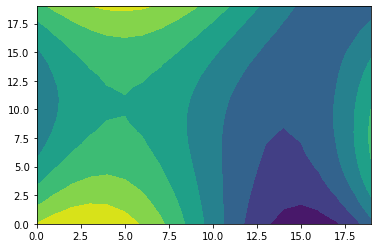

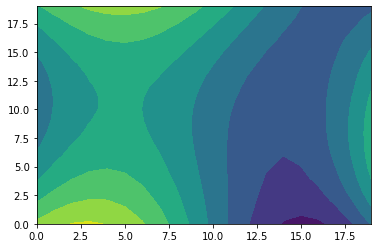

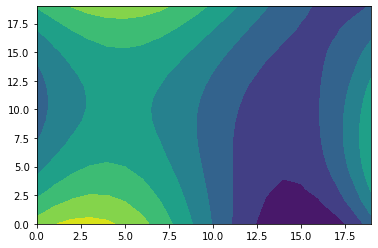

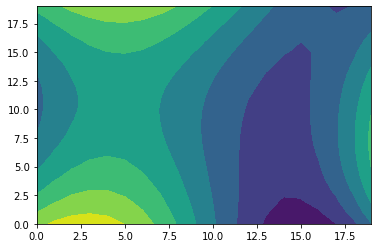

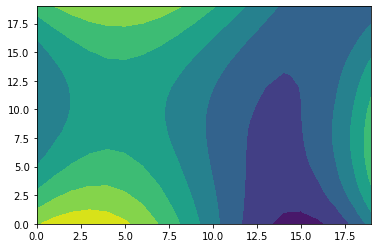

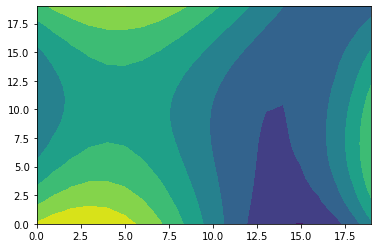

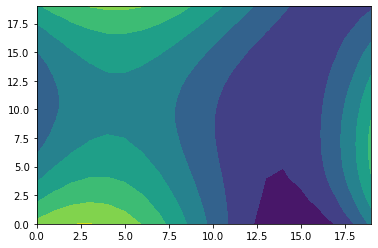

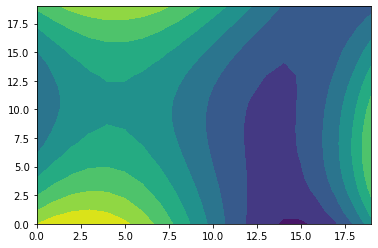

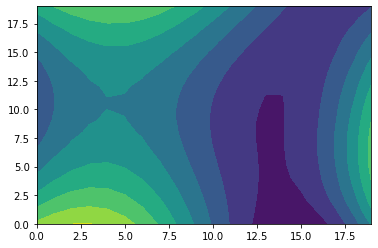

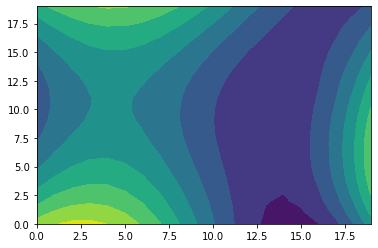

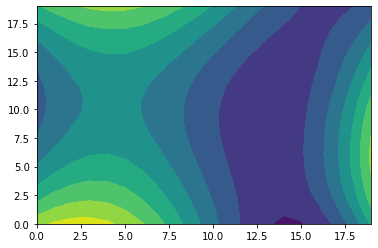

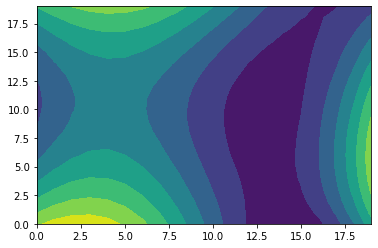

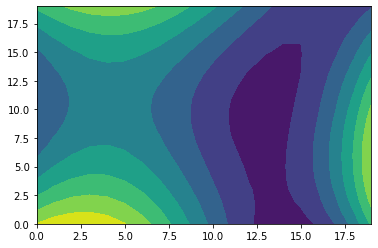

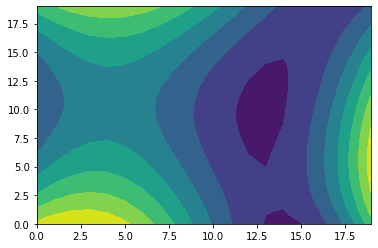

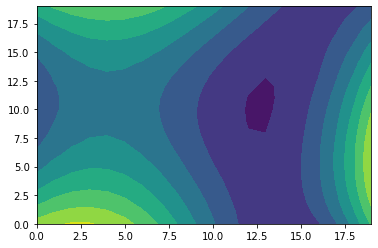

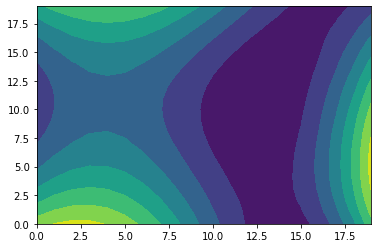

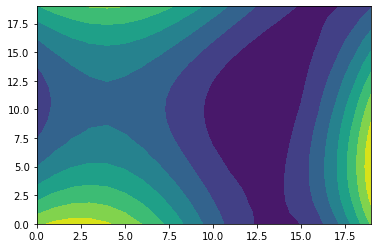

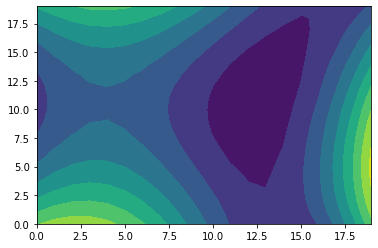

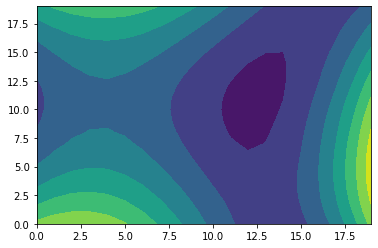

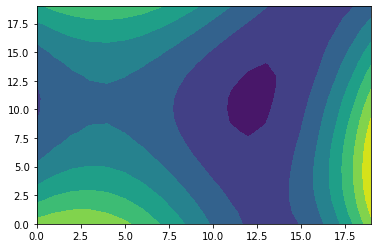

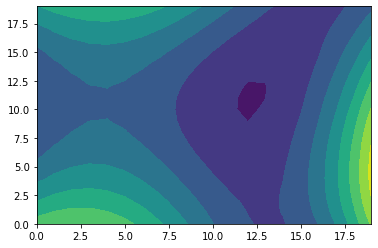

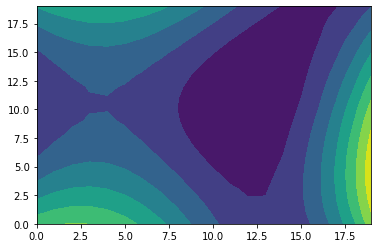

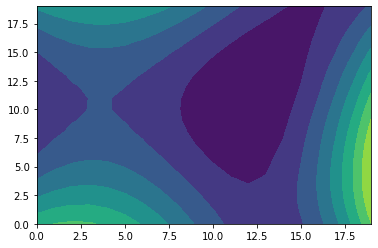

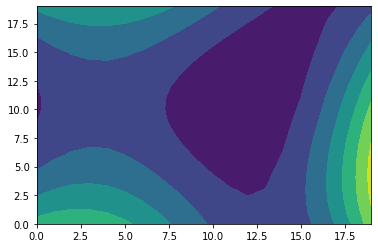

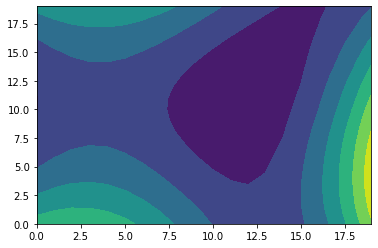

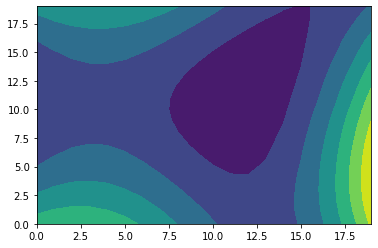

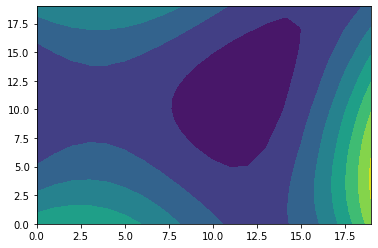

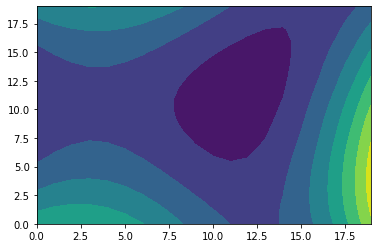

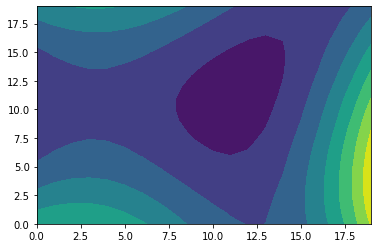

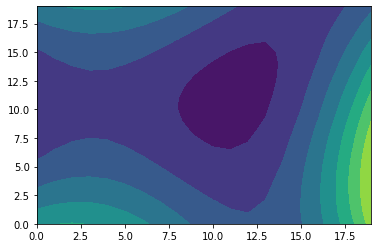

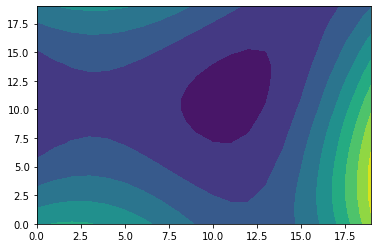

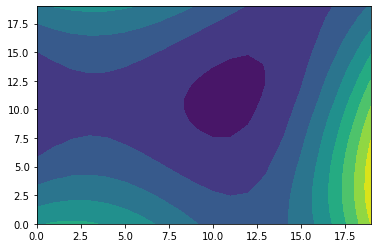

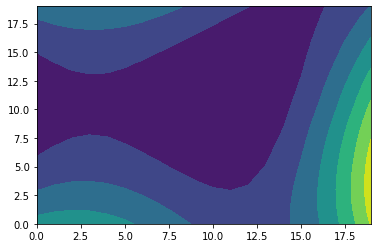

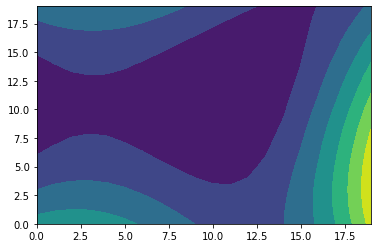

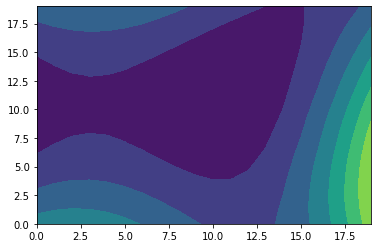

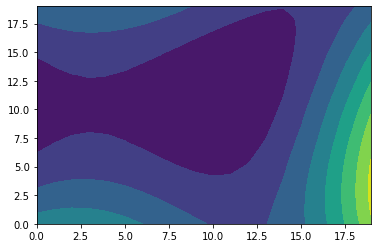

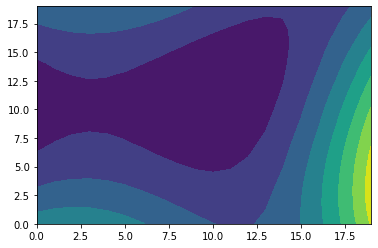

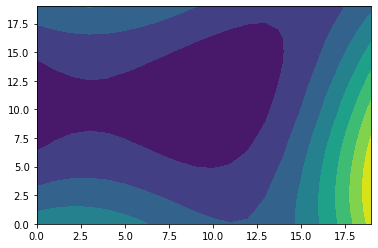

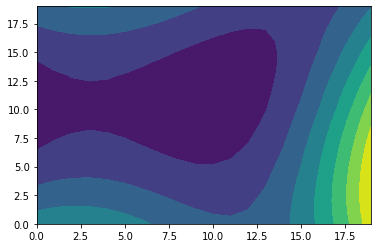

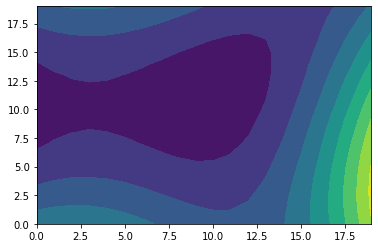

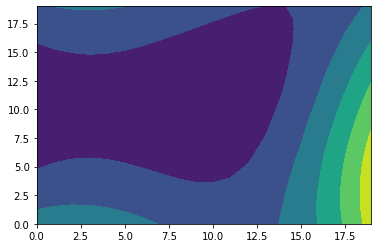

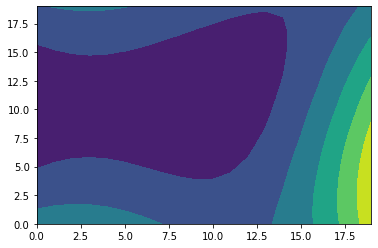

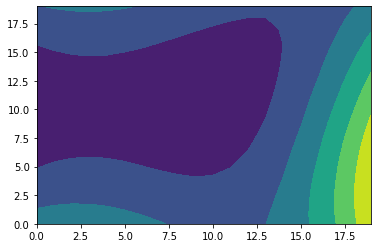

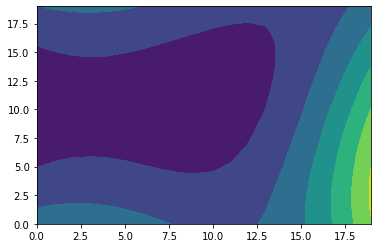

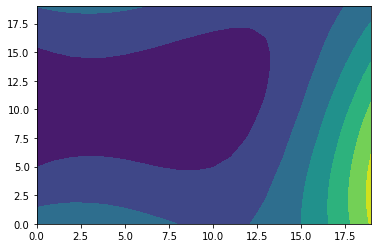

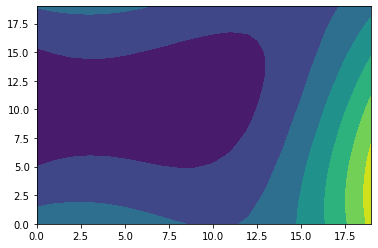

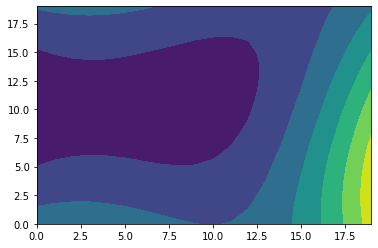

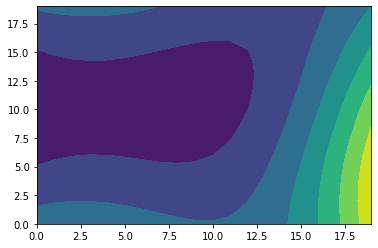

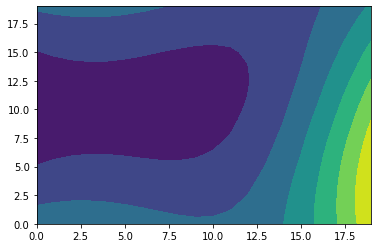

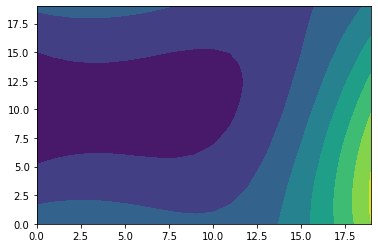

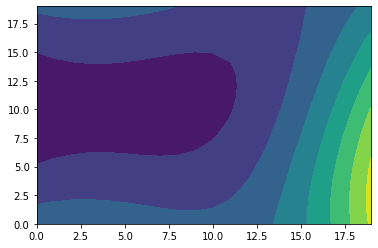

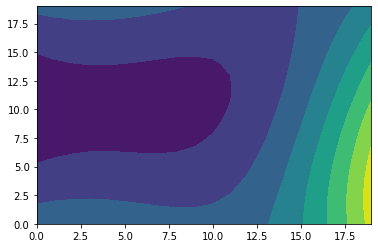

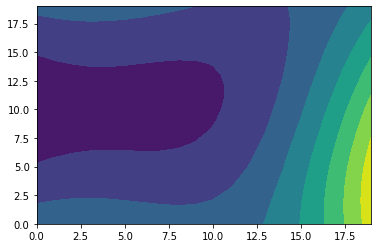

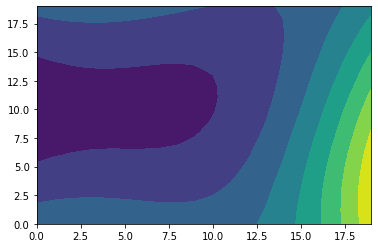

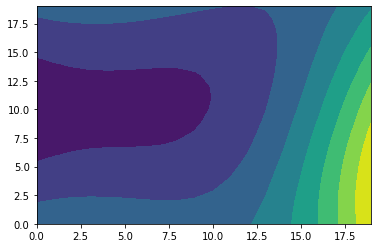

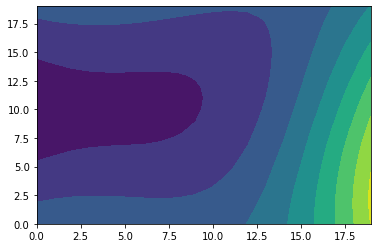

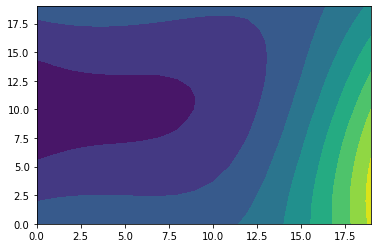

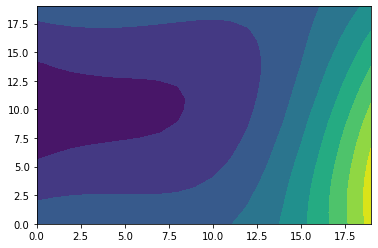

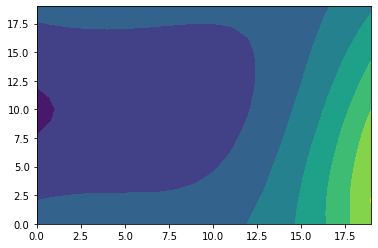

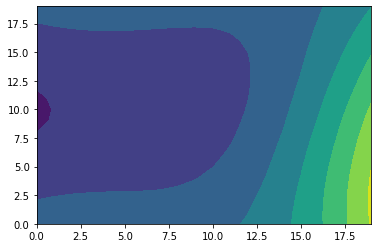

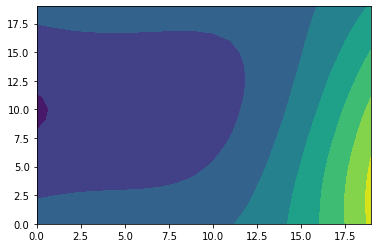

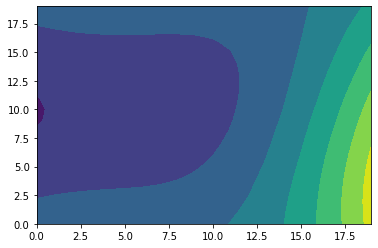

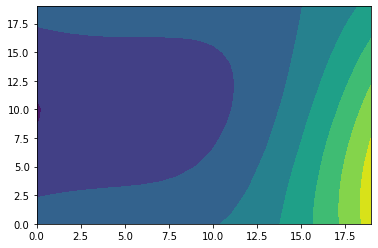

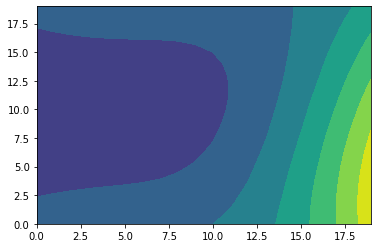

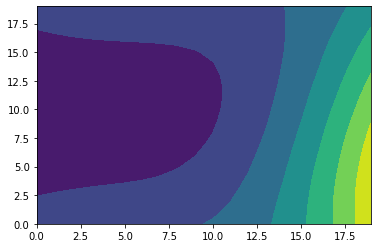

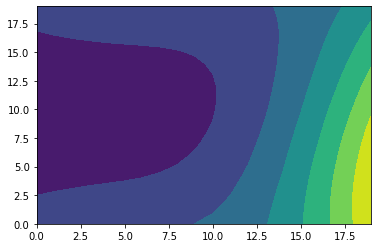

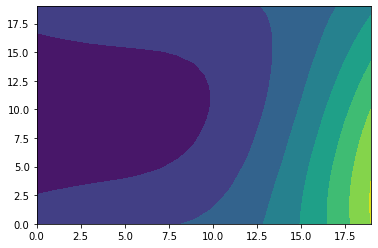

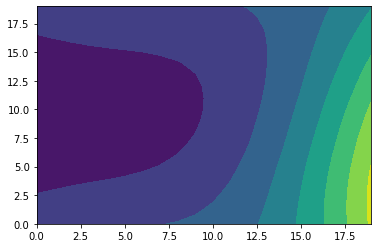

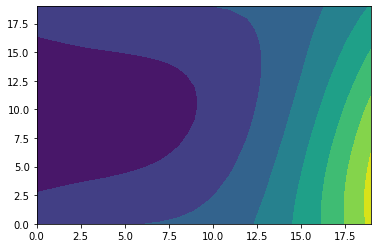

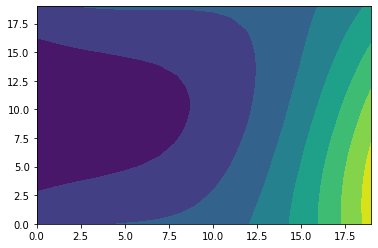

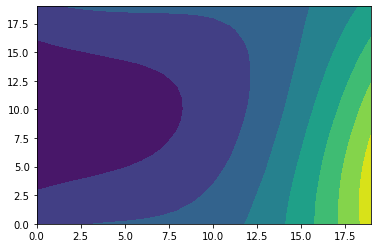

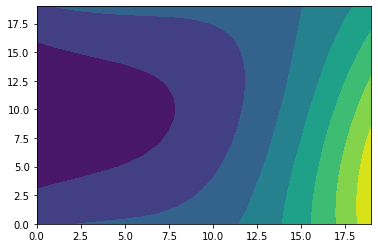

In [0]:
X_star = x
Y_star = y
T_star = t
u_pred, v_pred, p_pred = model.predict(X_star, Y_star, T_star)
print(u_pred.shape)

u_pred = u_pred.reshape(nx, ny, nt)
p_pred = p_pred.reshape(nx, ny, nt)

ims = []
fig = plt.figure()
for i in range(nt):
    im = plt.contourf(p_pred[:,:,i])
    plt.show()
    ims.append(im)
# anim = ArtistAnimation(fig, ims, interval=1, blit=False)
# from IPython.display import HTML
# HTML(anim.to_html5_video())
# plt.show()
# anim.save('/content/drive/My Drive/研究/Master/PINN_with_BC/anim.gif', writer='imagemagick')


# phi_pred = p_pred[:,:,9]
# fig, ax = plt.subplots()
# heatmap = ax.pcolor(phi_pred, cmap='hsv')
# fig.colorbar(heatmap, ax=ax)
# plt.show()

# # x=199
# phi_x199 = phi_pred[:, 99]
# plt.plot(Y, phi_x199)
# plt.show()

# # x=0
# phi_x0 = phi_pred[:,0]
# plt.plot(Y, phi_x0)
# plt.show()

iteration No = 0 delta= 1.0
iteration No = 100 delta= 0.004842781541445573
iteration No = 200 delta= 0.002420701462174324
iteration No = 300 delta= 0.0016123736469536576
iteration No = 400 delta= 0.0012073464482272867


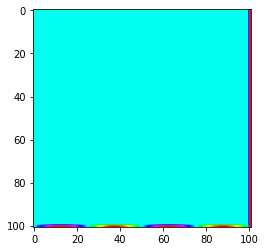

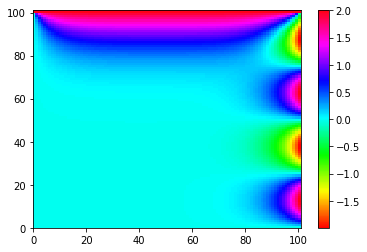

In [0]:

"""
ラプラス方程式: 数値解法, ヤコビ(Jacobi)法: 
12 Aug. 2017
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation # アニメーション作成のためのメソッドをインポート

fig = plt.figure()
anim = [] 

# 
delta_L=0.01  # グリッド幅
LL = 1 # 正方形の幅
L = int(LL/delta_L)

V = 5.0 # 1辺の境界の電位
convegence_criterion = 10**-3  # 収束条件。 精度を上げるならこの値を小さくする。

phi = np.zeros([L+1,L+1])
phi[0,:] = 0 # 境界条件
phi[:, 0] = 0
phi[-1, :] = 2*np.sin(np.linspace(0, LL, L+1)*4*np.pi)
phi[:, -1] = 2
phi2 = np.empty([L+1,L+1])

#for plot
im=plt.imshow(phi,cmap='hsv')
anim.append([im])


# メイン
delta = 1.0
n_iter=0
conv_check=[]
while delta > convegence_criterion:
    if n_iter % 100 ==0:  # 収束状況のモニタリング
        print("iteration No =", n_iter, "delta=",delta)
    conv_check.append([n_iter, delta])
    for i in range(L+1):
        for j in range(L+1):
            if i ==0 or i ==L or j==0 or j==L:
                phi2[i,j] = phi[i,j]
            else: 
                phi2[i,j] = (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4 # 補遺:式(11)を参照
    delta = np.max(abs(phi-phi2))

    phi, phi2 = phi2, phi
    n_iter+=1

    #im=plt.imshow(phi,cmap='hsv')
    #anim.append([im])

#for plot        
#plt.colorbar () # カラーバーの表示 
#plt.xlabel('X')
#plt.ylabel('Y')
#ani = ArtistAnimation(fig, anim, interval=100, blit=True,repeat_delay=1000)
#ani.save("t.gif", writer='imagemagick') 
# plot
fig, ax = plt.subplots()
phi = phi.T
heatmap = ax.pcolor(phi, cmap='hsv')
fig.colorbar(heatmap, ax=ax)
plt.show()

NameError: ignored

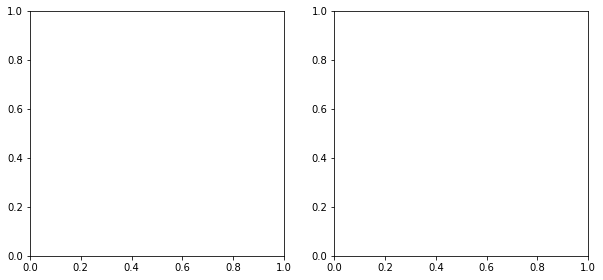

In [0]:
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
fs_suptitle  = 20
fs_title     = 16
fs_graticule = 12
fs_cbar      = 16

vmin, vmax = 0, 1200      ## colormap's range
cmap = plt.cm.jet

ticks = range(0,1201,200)    ## locations of labels of colorbar
ticklabels = ticks  
fig, axes = plt.subplots(1,2,figsize=(10,4.5))

axes[0].pcolor(phi_pred, cmap='hsv')
axes[1].pcolor(phi, cmap='hsv')
cmap = plt.cm.jet
## make mappable object for colorbar
norm = colors.Normalize(vmin=-2,vmax=2)
mappable = ScalarMappable(cmap=cmap,norm=norm)
mappable._A = []

## draw common colorbar
cb = fig.colorbar(mappable,ax=ax,aspect=50,pad=0.08,
                  shrink=0.8,orientation='horizontal')
cb.ax.tick_params(labelsize=fs_cbar)
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)

plt.show()